## 学校のクラス編成

前提
- 新年度における学校のクラス編成
- 特調や人数に偏りのないクラスを編成する必要がある

要請
- 全生徒は1つのクラスに所属する
    - 学年には318人の生徒がいて，8つのクラスがある
- 各クラスの生徒は，39人以上，40人以下
    - 学年に男子生徒が158人，女子生徒が160人いる
- 各クラスの男子生徒，女性との人数は20以下とする
    - 学力試験は500点満点で，平均点は303.6点
- 各クラスの学力試験の平均点は学年平均点±10点とする
- 各クラスにリーダー気質の生徒を2人以上割り当てる
    - 学年には17人いる
- 特別な支援が必要なが生徒は各クラスに1人以下とする
    - 学年には4人いる
- 特定ペアの生徒は同一クラスに割り当てない
    - そういったペアは3組ある

In [92]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [17]:
# 学生情報
df_student = pd.read_csv('data/3.school/students.csv')
df_student

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317
...,...,...,...,...,...
313,314,0,0,0,244
314,315,1,0,0,309
315,316,0,0,0,239
316,317,1,0,0,356


In [6]:
# student_idがきちんと連番になているか確かめる
print(df_student['student_id'].min())
print(df_student['student_id'].max())
print(len(df_student['student_id'].unique()) == len(df_student))

1
318
True


In [9]:
# gender
# 0 : 女性
# 1 : 弾性

pd.DataFrame(df_student['gender'].value_counts())

,gender
0,160
1,158


In [11]:
# テストの点数
pd.DataFrame(df_student['score'].describe())

,score
count,318.000000
mean,303.644654
std,65.179995
min,88.000000
25%,261.000000
50%,310.000000
75%,350.000000
max,485.000000


<AxesSubplot:>

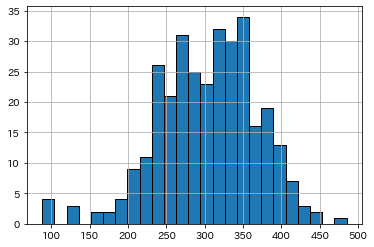

In [14]:
df_student['score'].hist(bins=25, ec='black')

In [15]:
df_student['leader_flag'].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [16]:
df_student['support_flag'].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

In [18]:
# 特定ペアの確認
df_pair = pd.read_csv('data/3.school/student_pairs.csv')
df_pair

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


- $S$ : 生徒の集合
- $C$ : クラスの集合
- $x_{s,c} \in \{0,1\}$ : 生徒$s \in S $をクラス$c \in C$に割り当てる場合に1そうでないなら0
- `要請1`：**各生徒は1つのクラスに割り当てる**
    - $\sum_{c\in C}\ x_{s,c}=1$
- `要請2`： **各クラスの生徒の人数は39人以上，40人以下**
    - $39 \le \sum_{s\in S}\ x_{s,c} \le 40 \ \ \ (c \in C)$
- `要請3`： **各クラスの男子生徒，女子生徒の人数は20人以下とする**
    - $\sum_{s\in S_{male}}\ x_{s,c} \le 20$
    - $\sum_{s\in S_{female}}\ x_{s,c} \le 20$
- `要請4`： **各クラスの学力試験の平均点は学年平均点±10点とする**
    - $score\_mean - 10 \le \frac{\sum_{s\in S}\ score_{s}\cdot x_{s,c}}{\sum_{s\in S}\ x_{s,c}} \le score\_mean + 10 \ \ \ (c \in C)$
- `要請5`： **各クラスにリーダー気質の生徒を2人以上割り当てる**
    - $\sum_{s \in S_{leader}}\ x_{s,c} \ge 2\ \ \ (c\in C)$
- `要請6`： **特別な支援が必要な生徒は各クラスに1人以下とする**
     - $\sum_{s\in S_{support}}\ x_{s,c} \le 1$
- `要請7`： **特定のペアの生徒は同一クラスに割り当てない**
     - $x_{s1,c} + x_{s2,c} \le 1 \ (c\in C, (s_1,s_2) \in SS) \ \ \$ (SS: 生徒の特定ペアリスト)

In [80]:
# 数理モデルのインスタンス
problem = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize) # 今回は目的変数はないので第2引数はあんま関係ない


S = df_student['student_id'].unique().tolist()
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# 生徒 - クラスの直積集合
SC = [(s,c) for s in S for c in C]
# 変数
# 生徒はどのクラスに割り当てられるか
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# 要件1：各生徒は1つのクラスに割り当てる
for s in S:
    problem.addConstraint(pulp.lpSum([x[s,c] for c in C]) == 1)
# 要請2： 各クラスの生徒の人数は39人以上，40人以下
for c in C:
    problem.addConstraint(pulp.lpSum([x[s,c] for s in S]) >= 39)
    problem.addConstraint(pulp.lpSum([x[s,c] for s in S]) <= 40)
# 要請3： 各クラスの男子生徒，女子生徒の人数は20人以下とする
males = [ row.student_id for row in df_student.itertuples() if row.gender==1]
females = [ row.student_id for row in df_student.itertuples() if row.gender==0]
for c in C:
    problem.addConstraint(pulp.lpSum([x[s,c] for s in males]) <= 20)
    problem.addConstraint(pulp.lpSum([x[s,c] for s in females]) <= 20)
# 要請4： 各クラスの学力試験の平均点は学年平均点±10点とする
score_mean = df_student['score'].mean()
score = {row.student_id:row.score for row in df_student.itertuples()}
for c in C:
    problem.addConstraint( (score_mean-10)*pulp.lpSum([x[s,c] for s in S]) <= pulp.lpSum([x[s,c]*score[s] for s in S]) )
    problem.addConstraint( pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean*10)*pulp.lpSum([x[s,c] for s in S]) )
# 要請5： 各クラスにリーダー気質の生徒を2人以上割り当てる
leaders = [row.student_id for row in df_student.itertuples() if row.leader_flag == 1]
for c in C:
    problem.addConstraint(pulp.lpSum(x[s,c] for s in leaders) >= 2)
# 要請6： 特別な支援が必要な生徒は各クラスに1人以下とする
supports = [row.student_id for row in df_student.itertuples() if row.support_flag==1]
for c in C:
    problem.addConstraint(pulp.lpSum(x[s,c] for s in supports) <= 1)
# 要請7： 特定のペアの生徒は同一クラスに割り当てない
SS = [(row.student_id1, row.student_id2) for row in df_pair.itertuples()]
for c in C:
    for s1, s2 in SS:
        problem.addConstraint(x[s1,c] + x[s2, c] <= 1)

# 求解
status = problem.solve()
print(status)
print(pulp.LpStatus[status])

1
Optimal


In [81]:
# 結果
members = {}
for c in C:
    members[c] = [s for s in S if x[s,c].value()==1]

for c, ss in members.items():
    print(f"クラス: {c}")
    print(f"{len(ss)} 名")
    print(f"生徒一覧 \n {ss}")
    print('-'*100)

クラス: A
40 名
生徒一覧 
 [1, 4, 16, 19, 22, 30, 33, 37, 44, 51, 62, 66, 67, 73, 82, 89, 96, 100, 111, 154, 172, 175, 201, 218, 234, 238, 242, 244, 258, 264, 269, 270, 282, 284, 290, 294, 304, 305, 309, 315]
----------------------------------------------------------------------------------------------------
クラス: B
39 名
生徒一覧 
 [3, 5, 8, 11, 26, 27, 36, 45, 54, 57, 58, 60, 86, 90, 102, 106, 118, 135, 142, 151, 162, 163, 171, 174, 187, 188, 191, 192, 195, 212, 214, 225, 230, 232, 245, 268, 295, 303, 306]
----------------------------------------------------------------------------------------------------
クラス: C
40 名
生徒一覧 
 [6, 35, 39, 52, 71, 74, 88, 92, 105, 109, 117, 123, 128, 133, 140, 145, 150, 157, 170, 173, 180, 181, 199, 200, 203, 204, 216, 229, 236, 246, 256, 259, 261, 274, 291, 299, 302, 310, 311, 312]
----------------------------------------------------------------------------------------------------
クラス: D
40 名
生徒一覧 
 [15, 17, 18, 25, 28, 38, 40, 50, 56, 80, 93, 103, 113, 115, 120, 122

**最適化ソルバーが出した答えが要件を満たしているか確認する**

In [82]:
# 要請1：各生徒は1つのクラスに割り当てる
for s in S:
    assigned_class = [x[s,c].value() for c in C if x[s,c].value()==1]
    if len(assigned_class)!=1:
        print(f"error: {s}")

In [83]:
S2C = {s:c for s in S for c in C if x[s,c].value()==1}
df_result = df_student.copy()
df_result['class'] = df_result['student_id'].map(S2C)
df_result

,student_id,gender,leader_flag,support_flag,score,class
0,1,0,0,0,335,A
1,2,1,0,0,379,H
2,3,0,0,0,350,B
3,4,0,0,0,301,A
4,5,1,0,0,317,B
...,...,...,...,...,...,...
313,314,0,0,0,244,H
314,315,1,0,0,309,A
315,316,0,0,0,239,G
316,317,1,0,0,356,E


In [84]:
# 要請2： 各クラスの生徒の人数は39人以上，40人以下
pd.DataFrame(df_result.groupby(['class'])['student_id'].nunique())

,student_id
class,
A,40
B,39
C,40
D,40
E,40
F,39
G,40
H,40


In [85]:
# 要請3： 各クラスの男子生徒，女子生徒の人数は20人以下とする
pd.DataFrame(df_result.groupby(['class', 'gender'])['student_id'].nunique())

student_id
class gender            
A     0               20
      1               20
B     0               20
      1               19
C     0               20
      1               20
D     0               20
      1               20
E     0               20
      1               20
F     0               20
      1               19
G     0               20
      1               20
H     0               20
      1               20

In [86]:
# 要請4： 各クラスの学力試験の平均点は学年平均点±10点とする
tmp = pd.DataFrame(df_result.groupby(['class'])['score'].mean())
print(score_mean)
tmp['diff'] = tmp['score'] - score_mean
tmp['is_ok'] = np.where(tmp['diff'].abs() <= 10, True, False)
tmp

303.6446540880503


,score,diff,is_ok
class,,,
A,309.900000,6.255346,True
B,296.974359,-6.670295,True
C,294.775000,-8.869654,True
D,293.850000,-9.794654,True
E,300.750000,-2.894654,True
F,294.538462,-9.106193,True
G,295.075000,-8.569654,True
H,342.900000,39.255346,False


In [87]:
# 要請5： 各クラスにリーダー気質の生徒を2人以上割り当てる
df_result.groupby(['class'])['leader_flag'].sum()

class
A    2
B    2
C    2
D    3
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [88]:
# 要請6： 特別な支援が必要な生徒は各クラスに1人以下とする
df_result.groupby(['class'])['support_flag'].sum()

class
A    0
B    1
C    0
D    1
E    0
F    1
G    1
H    0
Name: support_flag, dtype: int64

In [79]:
# 要請7： 特定のペアの生徒は同一クラスに割り当てない
for i, (s1, s2) in enumerate(SS):
    print('case', i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print(f"s1 : {s1}-{c1}")
    print(f"s2 : {s2}-{c2}")
    print('-'*30)

case 0
s1 : 118-B
s2 : 189-D
------------------------------
case 1
s1 : 72-G
s2 : 50-D
------------------------------
case 2
s1 : 314-H
s2 : 233-D
------------------------------


**モデルの改善**

In [89]:
# 点数は平均点±10だったが，標準偏差はどうか？

In [90]:
df_result.groupby(['class']).agg({'score': ['mean', 'std']})

score            
             mean         std
class                        
A      309.900000   51.368353
B      296.974359   35.935972
C      294.775000  106.732228
D      293.850000   42.010713
E      300.750000   73.809787
F      294.538462   46.511937
G      295.075000   47.867546
H      342.900000   74.968985

In [100]:
C

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

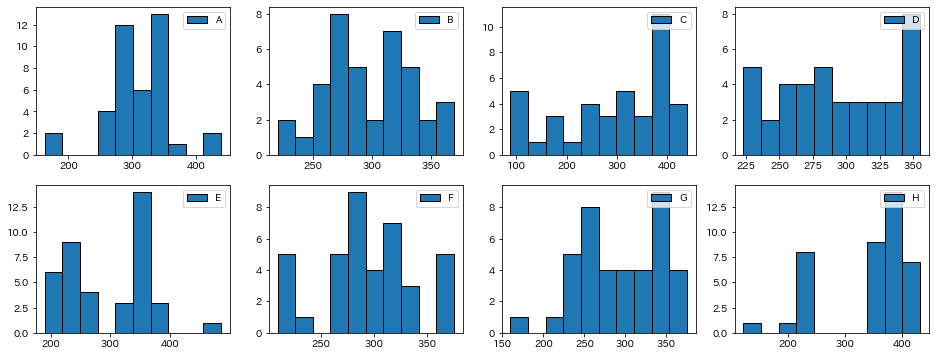

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
for i, ax in enumerate(axes.ravel()):
    ax.hist(df_result[df_result['class']==C[i]]['score'], ec='black', label=C[i])
    ax.legend(loc = 'upper right')
fig.show()

分布が汚い
- 学力順で生徒を各クラスに割り当てる
- クラス間で配置替えを繰り返し，要件を満たすようにクラスを再編する

最初に分布の偏らないクラスを作成しておいて，あとから制約を付けて配置替えを繰り返し，初期クラスに近づけていく
- 初期クラス編成フラグを$init\_flag_{s,c}$
- 目的関数
    - $maximize \ \sum_{s\in S, c\in C} \ x_{s,c}\cdot init\_flag_{s,c}$

In [104]:
# 初期クラス：点数が高いほうから順番に割り振る
df_student['score_rank'] = df_student['score'].rank(ascending=False, method='first')
class_dict = {i:C[i] for i in range(8)}
df_student['init_class'] = df_student['score_rank'].map(lambda x : x%8).map(class_dict)
df_student

,student_id,gender,leader_flag,support_flag,score,score_rank,init_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D
...,...,...,...,...,...,...,...
313,314,0,0,0,244,263.0,H
314,315,1,0,0,309,162.0,C
315,316,0,0,0,239,272.0,A
316,317,1,0,0,356,63.0,H


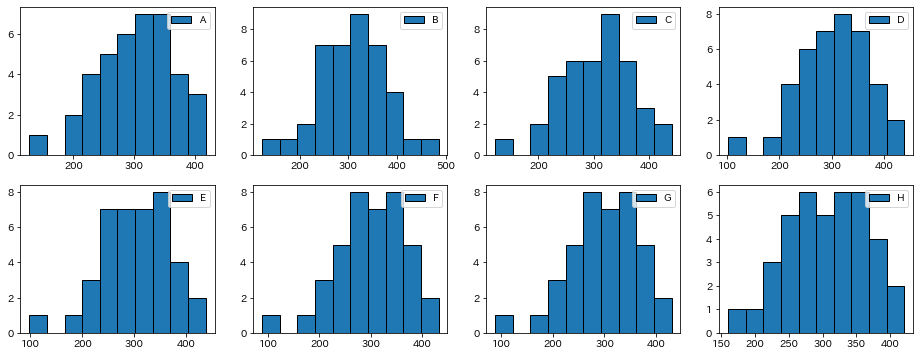

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
for i, ax in enumerate(axes.ravel()):
    ax.hist(df_result[df_student['init_class']==C[i]]['score'], ec='black', label=C[i])
    ax.legend(loc = 'upper right')
fig.show()

    こんなかんじの分布が作れればよい！

In [107]:
init_flag = {(s,c):0 for s in S for c in C}
for row in df_student.itertuples():
    init_flag[row.student_id, row.init_class] = 1

In [108]:
# 数理モデルのインスタンス
problem = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize) # 今回は目的変数はないので第2引数はあんま関係ない


S = df_student['student_id'].unique().tolist()
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# 生徒 - クラスの直積集合
SC = [(s,c) for s in S for c in C]
# 変数
# 生徒はどのクラスに割り当てられるか
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# 要件1：各生徒は1つのクラスに割り当てる
for s in S:
    problem.addConstraint(pulp.lpSum([x[s,c] for c in C]) == 1)
# 要請2： 各クラスの生徒の人数は39人以上，40人以下
for c in C:
    problem.addConstraint(pulp.lpSum([x[s,c] for s in S]) >= 39)
    problem.addConstraint(pulp.lpSum([x[s,c] for s in S]) <= 40)
# 要請3： 各クラスの男子生徒，女子生徒の人数は20人以下とする
males = [ row.student_id for row in df_student.itertuples() if row.gender==1]
females = [ row.student_id for row in df_student.itertuples() if row.gender==0]
for c in C:
    problem.addConstraint(pulp.lpSum([x[s,c] for s in males]) <= 20)
    problem.addConstraint(pulp.lpSum([x[s,c] for s in females]) <= 20)
# 要請4： 各クラスの学力試験の平均点は学年平均点±10点とする
score_mean = df_student['score'].mean()
score = {row.student_id:row.score for row in df_student.itertuples()}
for c in C:
    problem.addConstraint( (score_mean-10)*pulp.lpSum([x[s,c] for s in S]) <= pulp.lpSum([x[s,c]*score[s] for s in S]) )
    problem.addConstraint( pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean*10)*pulp.lpSum([x[s,c] for s in S]) )
# 要請5： 各クラスにリーダー気質の生徒を2人以上割り当てる
leaders = [row.student_id for row in df_student.itertuples() if row.leader_flag == 1]
for c in C:
    problem.addConstraint(pulp.lpSum(x[s,c] for s in leaders) >= 2)
# 要請6： 特別な支援が必要な生徒は各クラスに1人以下とする
supports = [row.student_id for row in df_student.itertuples() if row.support_flag==1]
for c in C:
    problem.addConstraint(pulp.lpSum(x[s,c] for s in supports) <= 1)
# 要請7： 特定のペアの生徒は同一クラスに割り当てない
SS = [(row.student_id1, row.student_id2) for row in df_pair.itertuples()]
for c in C:
    for s1, s2 in SS:
        problem.addConstraint(x[s1,c] + x[s2, c] <= 1)
        
""" 追加 """
problem.setObjective(pulp.lpSum(x[s,c] * init_flag[s,c] for s,c in SC))

# 求解
status = problem.solve()
print(status)
print(pulp.LpStatus[status])

1
Optimal


In [109]:
for s in S:
    assigned_class = [x[s,c].value() for c in C if x[s,c].value()==1]
    if len(assigned_class)!=1:
        print(f"error: {s}")

S2C = {s:c for s in S for c in C if x[s,c].value()==1}
df_result = df_student.copy()
df_result['class'] = df_result['student_id'].map(S2C)
df_result

,student_id,gender,leader_flag,support_flag,score,score_rank,init_class,class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D
...,...,...,...,...,...,...,...,...
313,314,0,0,0,244,263.0,H,G
314,315,1,0,0,309,162.0,C,C
315,316,0,0,0,239,272.0,A,A
316,317,1,0,0,356,63.0,H,H


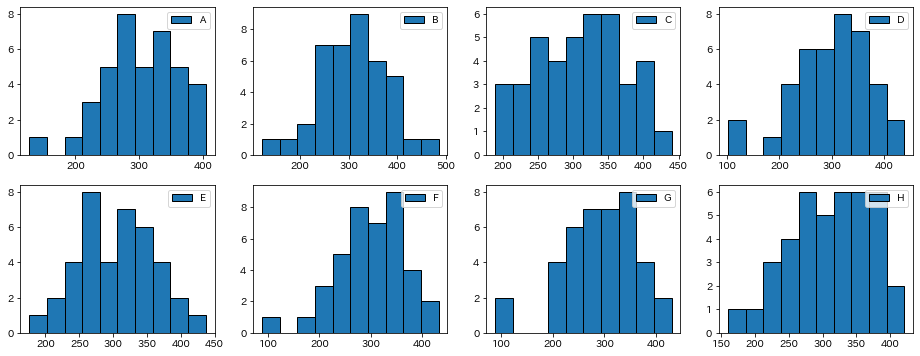

In [110]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
for i, ax in enumerate(axes.ravel()):
    ax.hist(df_result[df_result['class']==C[i]]['score'], ec='black', label=C[i])
    ax.legend(loc = 'upper right')
fig.show()

    よくなった